In [1]:
import pandas as pd
import numpy as np
import json
import re

In [2]:
with open('data/humset_bias_train.jsonl', 'r') as file:
    json_lines = [json.loads(line) for line in file]

In [3]:
len(json_lines)

165986

In [4]:
json_lines[0]

{'entry_id': 150780,
 'excerpt': "En plus du fret, les deux aéroports principaux  ( Ouagadougou et Bobo fret, Dioulasso )  sont partiellement ouverts à l'entrée des ressortissants burkinabè en provenance des pays étrangers. Ces derniers sont placés en quarantaine pendant deux semaines à leur arrivée à Ouagadougou ou à Bobo Dioulasso. Cependant, aux points d'entrée terrestre certaines personnes contournent les voies officielles pour rentrer ou sortir du Burkina Faso",
 'lang': 'fr',
 'excerpt_type': 'original',
 'gender_context_falsing_kw': [],
 'gender_keywords': [],
 'gender_kword_type': [],
 'country_context_falsing_kw': ['us'],
 'country_keywords': [],
 'country_kword_type': [],
 'sectors': ['Logistics'],
 'pillars_1d': ['Covid-19'],
 'pillars_2d': ['Impact'],
 'subpillars_1d': ['Covid-19->Restriction measures'],
 'subpillars_2d': ['Impact->Impact on systems, services and networks']}

In [5]:
english_train = [line for line in json_lines if line['lang'] == 'en']

In [6]:
len(english_train)

113184

In [7]:
json_lines[0]

{'entry_id': 150780,
 'excerpt': "En plus du fret, les deux aéroports principaux  ( Ouagadougou et Bobo fret, Dioulasso )  sont partiellement ouverts à l'entrée des ressortissants burkinabè en provenance des pays étrangers. Ces derniers sont placés en quarantaine pendant deux semaines à leur arrivée à Ouagadougou ou à Bobo Dioulasso. Cependant, aux points d'entrée terrestre certaines personnes contournent les voies officielles pour rentrer ou sortir du Burkina Faso",
 'lang': 'fr',
 'excerpt_type': 'original',
 'gender_context_falsing_kw': [],
 'gender_keywords': [],
 'gender_kword_type': [],
 'country_context_falsing_kw': ['us'],
 'country_keywords': [],
 'country_kword_type': [],
 'sectors': ['Logistics'],
 'pillars_1d': ['Covid-19'],
 'pillars_2d': ['Impact'],
 'subpillars_1d': ['Covid-19->Restriction measures'],
 'subpillars_2d': ['Impact->Impact on systems, services and networks']}

In [8]:
new_df = []
for line in english_train:
    id_ = line['entry_id']
    text = line['excerpt']
    if not isinstance(text, str):
        continue
    text = re.sub(r"\[.*?\]\s*", "", text)
    text = text.strip()
    sub_1d = line['subpillars_1d']
    sub_2d = line['subpillars_2d']
    subs = sub_1d + sub_2d
    subs = list(set(subs))
    new_df.append({'id': id_, 'text': text, 'subpillars': subs})

In [13]:
with open('data/humset_bias_train_en.jsonl', 'w') as file:
    for line in new_df:
        file.write(json.dumps(line) + '\n')

In [20]:
df_no_empty = [x for x in new_df if x['subpillars'] != []]
df_no_long = [x for x in df_no_empty if len(x['text']) < 512]
df_empty_no_long = [x for x in new_df if len(x['text']) < 512]
with open('data/humset_bias_train_en_no_long.jsonl', 'w') as file:
    for line in df_no_long:
        file.write(json.dumps(line) + '\n')
with open('data/humset_bias_train_en_no_empty.jsonl', 'w') as file:
    for line in df_no_empty:
        file.write(json.dumps(line) + '\n')
with open('data/humset_bias_train_en_empty_no_long.jsonl', 'w') as file:
    for line in df_empty_no_long:
        file.write(json.dumps(line) + '\n')

In [37]:
merges = {
    'Shock/event->Mitigating factors': 'Shock/event->Underlying/aggravating factors',
    'Capacities & response->Red cross/red crescent': 'Capacities & response->National response',
    'Capacities & response->Local response': 'Capacities & response->National response',
    'Covid-19->Research and outlook': 'Covid-19->Testing',
    'Humanitarian access->Population to relief': 'Humanitarian access->Relief to population',
    'Displacement->Intentions': 'Displacement->Pull factors',
    'Priority interventions->Expressed by population': 'Priority interventions->Expressed by humanitarian staff',
    'Casualties->Missing': 'Casualties->Injured',
    'Information and communication->Information challenges and barriers': 'Information and communication->Knowledge and info gaps (hum)'
}

In [38]:
merged_data = []
for line in df_no_long:
    subs = line['subpillars']
    new_subs = []
    for sub in subs:
        if sub in merges:
            new_subs.append(merges[sub])
        else:
            new_subs.append(sub)
    merged_data.append({'id': line['id'], 'text': line['text'], 'subpillars': new_subs})

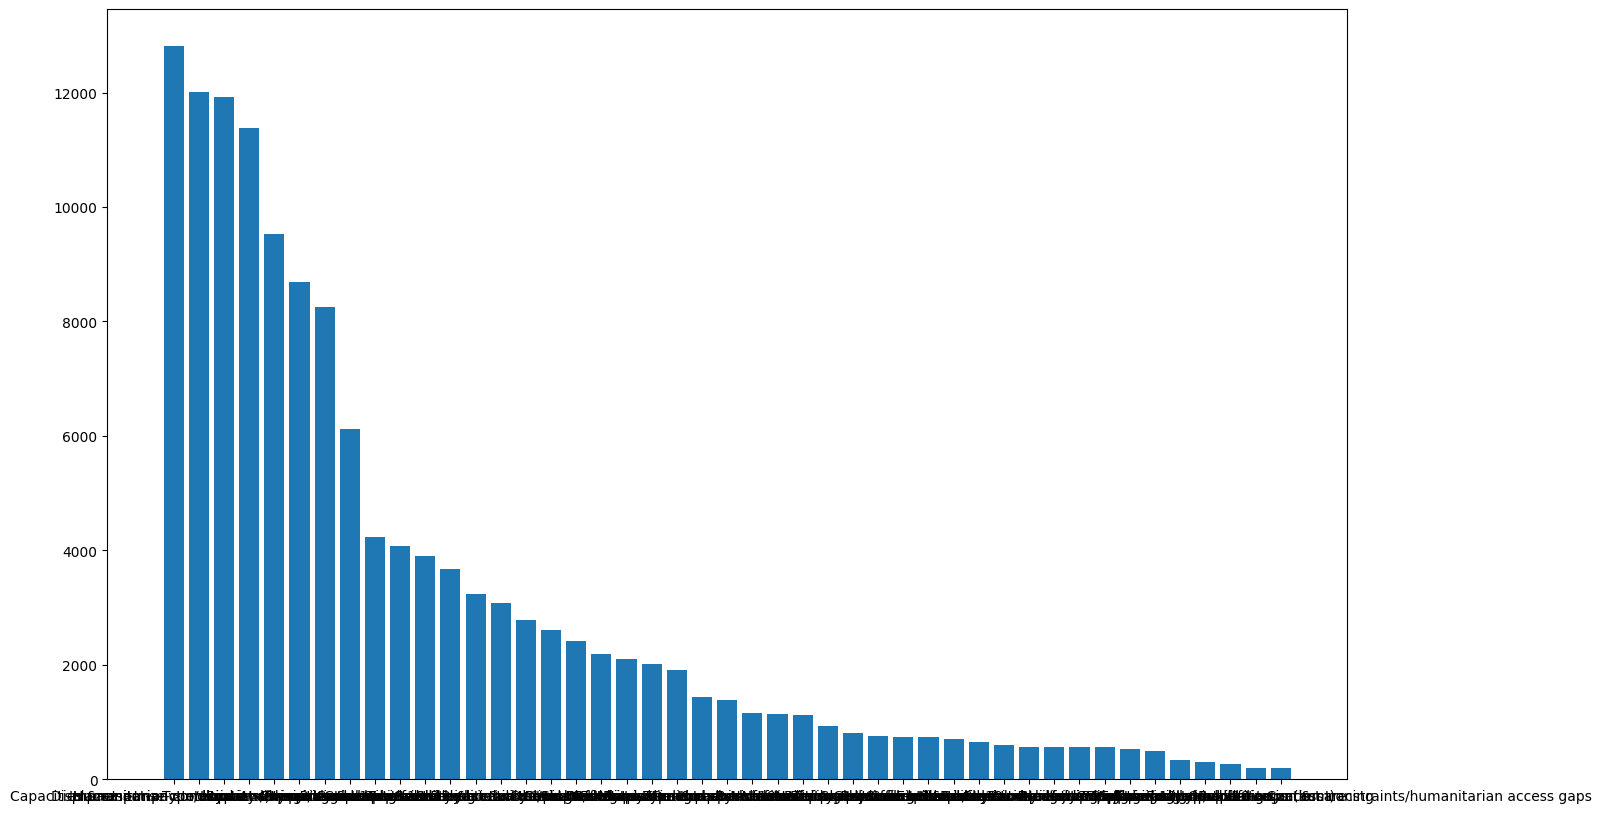

In [43]:
import matplotlib.pyplot as plt
import random
topic_freq = {}
for line in merged_data:
    for topic in line['subpillars']:
        if topic not in topic_freq:
            topic_freq[topic] = 0
        topic_freq[topic] += 1
top_topic_freq = [(k, v) for k, v in sorted(topic_freq.items(), key=lambda item: item[1], reverse=True)]
plt.figure(figsize=(16, 10))
plt.bar([x[0] for x in top_topic_freq], [x[1] for x in top_topic_freq])
plt.show()

In [44]:
top_7 = [x[0] for x in top_topic_freq[:7]]
low_5 = [x[0] for x in top_topic_freq[-5:]]

In [60]:
normalized_data = []
for line in merged_data:
    subs = line['subpillars']
    new_subs = []
    if all(sub in top_7 for sub in subs):
        if random.random() < 0.5:
            continue
    for sub in subs:
        if sub in low_5:
            continue
        if sub in top_7 and len(subs) == 1:
            if random.random() < 0.3:
                new_subs.append(sub)
        else:
            new_subs.append(sub)
    if len(new_subs) > 0:
        normalized_data.append({'id': line['id'], 'text': line['text'], 'subpillars': new_subs})

In [61]:
len(normalized_data)

57137

In [119]:
top_7

['Capacities & response->International response',
 'Displacement->Type/numbers/movements',
 'Humanitarian conditions->Living standards',
 'Impact->Impact on systems, services and networks',
 'Humanitarian conditions->Physical and mental well being',
 'Impact->Impact on people',
 'Impact->Driver/aggravating factors']

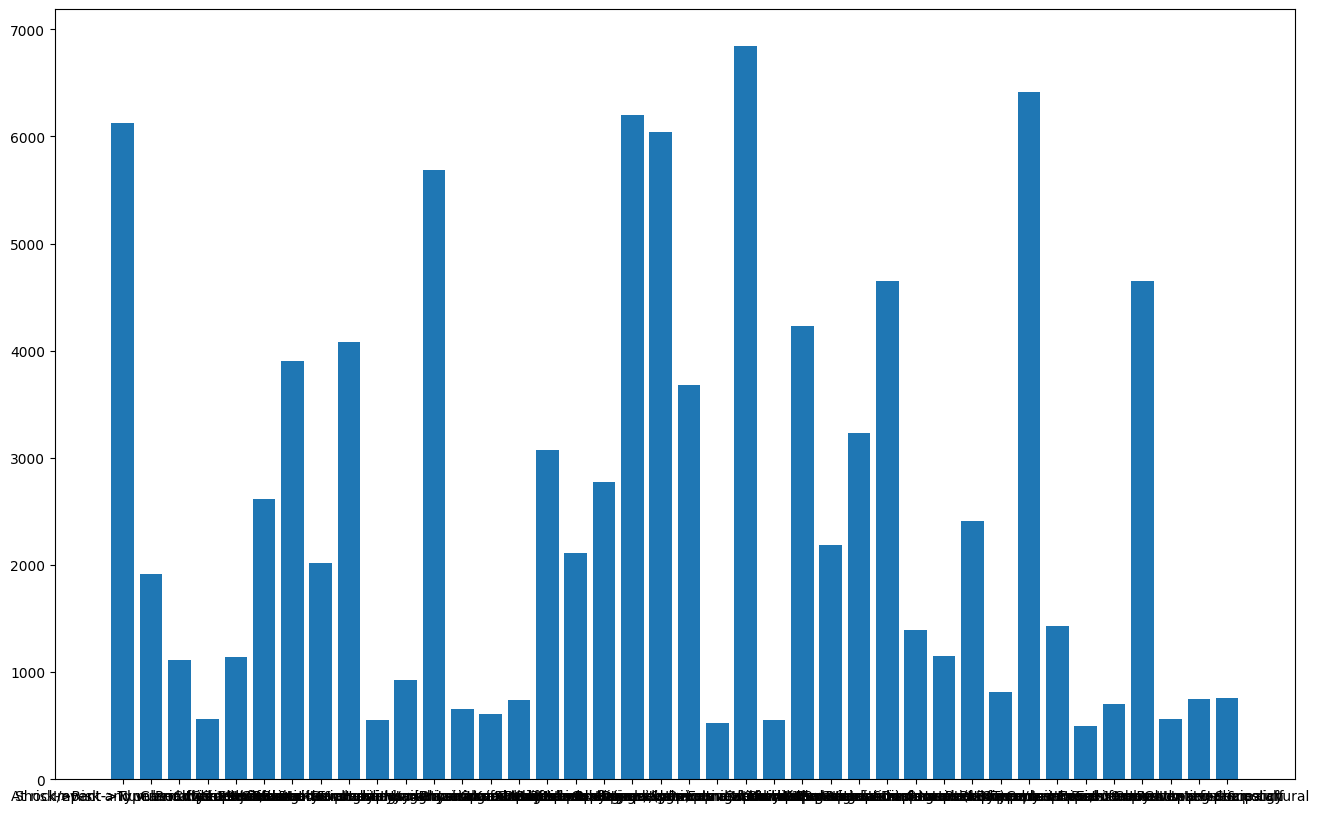

In [62]:
topic_freq = {}
for line in normalized_data:
    for topic in line['subpillars']:
        if topic not in topic_freq:
            topic_freq[topic] = 0
        topic_freq[topic] += 1
top_topic_freq = set([(k, v) for k, v in sorted(topic_freq.items(), key=lambda item: item[1], reverse=True)])
plt.figure(figsize=(16, 10))
plt.bar([x[0] for x in top_topic_freq], [x[1] for x in top_topic_freq])
plt.show()

In [63]:
len(set([(k, v) for k, v in sorted(topic_freq.items(), key=lambda item: item[1], reverse=True)]))

40

In [64]:
with open('data/humset_bias_train_en_normalized.jsonl', 'w') as file:
    for line in normalized_data:
        file.write(json.dumps(line) + '\n')

In [78]:
normalized_with_empty = normalized_data[:]
for line in df_empty_no_long:
    if line['subpillars'] == []:
        normalized_with_empty.append({'id': line['id'], 'text': line['text'], 'subpillars': []})
random.shuffle(normalized_with_empty)

In [80]:
with open('data/humset_bias_train_en_normalized_with_empty.jsonl', 'w') as file:
    for line in normalized_with_empty:
        file.write(json.dumps(line) + '\n')

In [10]:
print(len(new_df))
print(len(df_no_empty))
print(len(df_no_long))
print(len(df_empty_no_long))

113153
102808
86809
96441


In [20]:
topics_per_text = [len(x['subpillars']) for x in df_no_long]
freqs = pd.DataFrame(topics_per_text).value_counts()
freqs_with_perc = freqs / freqs.sum()
freqs_with_perc

1    0.603682
2    0.274061
3    0.088793
4    0.025239
5    0.006428
6    0.001348
7    0.000276
8    0.000161
9    0.000012
Name: count, dtype: float64

In [81]:
with open('data/humset_bias_val.jsonl', 'r') as file:
    json_lines_val = [json.loads(line) for line in file]

In [82]:
json_lines_val_en = [line for line in json_lines_val if line['lang'] == 'en']
print(len(json_lines_val_en))

10797


In [83]:
val_df = []
for line in json_lines_val_en:
    id_ = line['entry_id']
    text = line['excerpt']
    if not isinstance(text, str):
        continue
    text = re.sub(r"\[.*?\]\s*", "", text)
    text = text.strip()
    sub_1d = line['subpillars_1d']
    sub_2d = line['subpillars_2d']
    subs = sub_1d + sub_2d
    subs = list(set(subs))
    val_df.append({'id': id_, 'text': text, 'subpillars': subs})

In [99]:
val_df_no_empty = [x for x in val_df if x['subpillars'] != []]
val_df_no_long = [x for x in val_df_no_empty if len(x['text']) < 512]
val_df_empty_no_long = [x for x in val_df if len(x['text']) < 512]
len(val_df_no_long)

8448

In [115]:
val_df_empty_no_long_concat_by_5 = []
for i in range(0, len(val_df_empty_no_long)-5, 5):
    subp_set = set()
    for j in range(i, i+5):
        subp_set.update(val_df_empty_no_long[j]['subpillars'])
    val_df_empty_no_long_concat_by_5.append({
        'text': '~~'.join([x['text'] for x in val_df_empty_no_long[i:i+5]]),
        'subpillars': list(subp_set)
    })

In [116]:
with open('data/humset_bias_test_en_empty_no_long_concat_by_5.jsonl', 'w') as file:
    for line in val_df_empty_no_long_concat_by_5:
        file.write(json.dumps(line) + '\n')

In [85]:
val_df_merged = []
for line in val_df_no_long:
    subs = line['subpillars']
    new_subs = []
    for sub in subs:
        if sub in merges:
            new_subs.append(merges[sub])
        else:
            new_subs.append(sub)
    val_df_merged.append({'id': line['id'], 'text': line['text'], 'subpillars': new_subs})

In [86]:
val_normalized_data = []
for line in val_df_merged:
    subs = line['subpillars']
    new_subs = []
    if all(sub in top_7 for sub in subs):
        if random.random() < 0.5:
            continue
    for sub in subs:
        if sub in low_5:
            continue
        if sub in top_7 and len(subs) == 1:
            if random.random() < 0.3:
                new_subs.append(sub)
        else:
            new_subs.append(sub)
    if len(new_subs) > 0:
        val_normalized_data.append({'id': line['id'], 'text': line['text'], 'subpillars': new_subs})

In [100]:
val_normalized_data_with_empty = val_normalized_data[:]
for line in val_df_empty_no_long:
    if line['subpillars'] == []:
        val_normalized_data_with_empty.append({'id': line['id'], 'text': line['text'], 'subpillars': []})
random.shuffle(val_normalized_data_with_empty)

In [101]:
len(val_normalized_data_with_empty), len(val_normalized_data)

(6118, 5058)

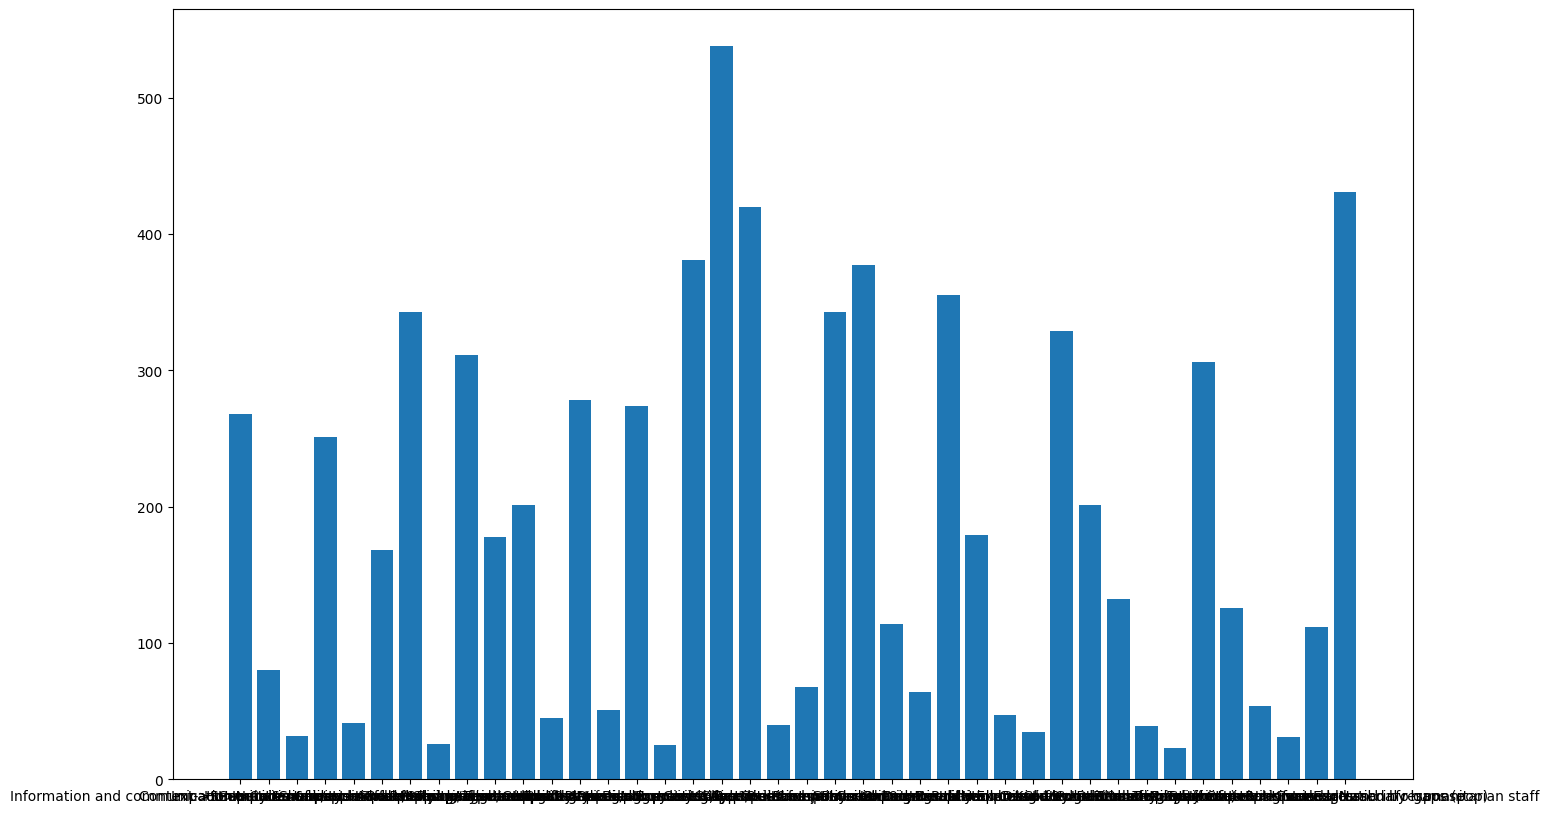

In [102]:
val_topic_freq = {}
for line in val_normalized_data:
    for topic in line['subpillars']:
        if topic not in val_topic_freq:
            val_topic_freq[topic] = 0
        val_topic_freq[topic] += 1
val_top_topic_freq = set([(k, v) for k, v in sorted(val_topic_freq.items(), key=lambda item: item[1], reverse=True)])
plt.figure(figsize=(16, 10))
plt.bar([x[0] for x in val_top_topic_freq], [x[1] for x in val_top_topic_freq])
plt.show()

In [103]:
with open('data/humset_bias_test_en_normalized_with_empty.jsonl', 'w') as file:
    for line in val_normalized_data_with_empty:
        file.write(json.dumps(line) + '\n')

In [114]:
unique_merged_topix = set([x[0] for x in top_topic_freq])
unique_merged_topix

{'At risk->Risk and vulnerabilities',
 'Capacities & response->International response',
 'Capacities & response->National response',
 'Capacities & response->People reached/response gaps',
 'Casualties->Dead',
 'Casualties->Injured',
 'Context->Demography',
 'Context->Economy',
 'Context->Environment',
 'Context->Legal & policy',
 'Context->Politics',
 'Context->Security & stability',
 'Context->Socio cultural',
 'Covid-19->Cases',
 'Covid-19->Deaths',
 'Covid-19->Prevention campaign',
 'Covid-19->Restriction measures',
 'Covid-19->Testing',
 'Covid-19->Vaccination',
 'Displacement->Push factors',
 'Displacement->Type/numbers/movements',
 'Humanitarian access->Physical constraints',
 'Humanitarian access->Relief to population',
 'Humanitarian conditions->Coping mechanisms',
 'Humanitarian conditions->Living standards',
 'Humanitarian conditions->Number of people in need',
 'Humanitarian conditions->Physical and mental well being',
 'Impact->Driver/aggravating factors',
 'Impact->Impact